In [5]:
links = ['https://www.imdb.com/search/title/?release_date=2010-01-01,&sort=boxoffice_gross_us,desc&count=250&start={}'.format(i) for i in range(1,5000,250)]

 

In [12]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Sorry for the long function, I worked a little backwards. I created all these variables on a different notebook for page 1. Bunched them together here for the sake of grabbing multiple pages


In [62]:
def page_contents(link):
    imdb_html = requests.get(link)
    soup = BeautifulSoup(imdb_html.content, 'html.parser')
    main_div_tag = soup.find('div', {'class':'lister-list'})
    movies_per_page = main_div_tag.find_all('div', {'class':'lister-item mode-advanced'})
    contents = []
    for item in movies_per_page:
        contents.append(item.find('div',{'class':'lister-item-content'}))
    movie_ids =[]
    for i in contents:
        movie_ids.append(i.find('h3').find('a')['href'].split('/')[2])
    movie_titles =[]
    for i in contents:
        movie_titles.append(str(i.find('h3').find('a')).split('>')[1].split('<')[0])
    years =[]
    for i in contents:
        year = str(i.find('h3').find('span', {'class':'lister-item-year text-muted unbold'})).split('(')[-1].split(')')[0]
        years.append(int(year))
    ratings =[]
    for i in contents:
        ratings.append(str(i.find('p').find('span',{'class':'certificate'})).split('>')[1].split('<')[0])
    runtimes =[]
    for i in contents:
        runtimes.append(str(i.find('p').find('span',{'class':'runtime'})).split('>')[1].split('<')[0].split()[0])
    genres = []
    for i in contents:
        clean_genre = []
        genres_unclean = str(i.find('p').find('span',{'class':'genre'})).split('>')[1].split('<')[0].split('\n')[1].split(',')
        for genr in genres_unclean:
            clean_genre.append(genr.strip())
        genres.append(clean_genre)
    imdb_rating = []
    for i in contents:
        imdb_rating.append(float(i.find('div',{'class':'inline-block ratings-imdb-rating'})['data-value']))
    meta_score_rating = []
    for i in contents:
        score = str(i.find('div',{'class':'inline-block ratings-metascore'}).find('span')).split('>')[1].split('<')[0].strip()
        meta_score_rating.append(int(score))
    votes =[]
    for i in contents:
        votes.append(int(str(i.find('p', {'class':'sort-num_votes-visible'}).find_all('span')[1]).split('>')[1].split('<')[0].replace(',','')))
    gross_rev =[]
    for i in contents:
        gross_rev.append(int(str(i.find('p',{'class':'sort-num_votes-visible'}).find_all('span')[4]).split('"')[1].replace(',','')))
    def get_text_from_a(a_tag):
        '''
        takes a 'a' tag argument from html and returns the text displayed
        '''
        return str(a_tag).split('>')[1].split('<')[0]
    directors =[]
    for i in contents:
        dirct =[]
        for i2 in i.find('p',{'class':''}):
            if i2 == i.find('p',{'class':''}).find('span'):
                break
            else:
                if i2 in i.find('p',{'class':''}).find_all('a'):
                    dirct.append(get_text_from_a(i2))
        directors.append(dirct)
    def get_stars(content):
        strz =[]
        for i2 in content.find('p',{'class':''}):
            if i2 in content.find('p',{'class':''}).find_all('a'):
                strz.append(get_text_from_a(i2))
            else:
                if i2 == content.find('p',{'class':''}).find('span'):
                    strz = []
                    continue
        return strz
    
    stars = [get_stars(i) for i in contents] 
    
    return pd.DataFrame({'id':movie_ids,'title':movie_titles,     
    'year':years,'ratings':ratings,'runtime':runtimes,
    'genre':genres,'imdb_rating':imdb_rating,
    'meta_score':meta_score_rating,
    'votes':votes,'revenue':gross_rev,
    'directors':directors,'stars':stars})

My function only worked for the first two pages..

In [63]:
# list of 2 dataframes
multiple_df = [page_contents(link) for link in links[:2]]

In [69]:
# combining dataframes into one
df = pd.concat(multiple_df,ignore_index=True)

In [71]:
# creating csv
df.to_csv('top_500_academy_winning_movies_by_box_office_2010-2020.csv')

In [119]:
df.head()

,id,title,year,ratings,runtime,genre,imdb_rating,meta_score,votes,revenue,directors,stars,num_of_stars,num_of_directors
0,tt2488496,Star Wars: Episode VII - The Force Awakens,2015,PG-13,138,"[Action, Adventure, Sci-Fi]",7.9,81,827705,936662225,[J.J. Abrams],"[Daisy Ridley, John Boyega, Oscar Isaac, Domhn...",4,1
1,tt4154796,Avengers: Endgame,2019,PG-13,181,"[Action, Adventure, Drama]",8.5,78,675448,858373000,"[Anthony Russo, Joe Russo]","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",4,2
2,tt1825683,Black Panther,2018,PG-13,134,"[Action, Adventure, Sci-Fi]",7.3,88,566449,700059566,[Ryan Coogler],"[Chadwick Boseman, Michael B. Jordan, Lupita N...",4,1
3,tt4154756,Avengers: Infinity War,2018,PG-13,149,"[Action, Adventure, Sci-Fi]",8.5,68,750737,678815482,"[Anthony Russo, Joe Russo]","[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",4,2
4,tt0369610,Jurassic World,2015,PG-13,124,"[Action, Adventure, Sci-Fi]",7.0,59,557059,652270625,[Colin Trevorrow],"[Chris Pratt, Bryce Dallas Howard, Ty Simpkins...",4,1


In [94]:
df['num_of_stars'] = df['stars'].map(lambda x: len(x))

In [96]:
df['num_of_directors'] = df['directors'].map(lambda x: len(x))

In [99]:
df[['directors','num_of_directors']]

,directors,num_of_directors
0,[J.J. Abrams],1
1,"[Anthony Russo, Joe Russo]",2
2,[Ryan Coogler],1
3,"[Anthony Russo, Joe Russo]",2
4,[Colin Trevorrow],1
...,...,...
495,[Nicholas Stoller],1
496,[Harold Cronk],1
497,[M. Night Shyamalan],1
498,[Scott Hicks],1


In [106]:
# list of directors and the count of how many movies they directed (in the dataset)
director_count ={}
for directors in df.directors:
    for director in directors:
        director_count[director] = director_count.get(director, 1) + 1

In [148]:
genres_count ={}
for genres in df.genre:
    for genre in genres:
        genres_count[genre] = genres_count.get(genre, 1) + 1

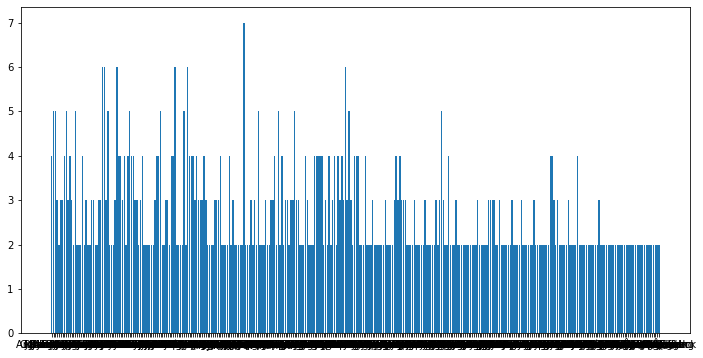

In [118]:
plt.figure(figsize=(12,6));
plt.bar(director_count.keys(),director_count.values());
plt.show()

In [147]:
director_count.values()

dict_values([4, 5, 5, 3, 2, 3, 3, 4, 5, 3, 4, 3, 2, 5, 2, 2, 2, 4, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3, 6, 6, 3, 5, 2, 2, 2, 3, 6, 4, 4, 3, 4, 2, 4, 5, 4, 4, 3, 3, 2, 3, 4, 2, 2, 2, 2, 2, 2, 3, 4, 4, 5, 2, 2, 3, 3, 2, 4, 4, 6, 2, 2, 2, 2, 5, 2, 6, 4, 4, 4, 3, 4, 3, 3, 3, 4, 3, 2, 2, 2, 2, 3, 3, 3, 4, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 7, 2, 2, 2, 3, 2, 3, 2, 5, 2, 2, 2, 3, 2, 2, 3, 3, 4, 2, 5, 2, 4, 2, 3, 3, 2, 3, 3, 5, 3, 3, 2, 2, 2, 4, 3, 2, 2, 2, 4, 4, 4, 4, 4, 2, 3, 2, 4, 2, 3, 4, 2, 4, 3, 4, 3, 6, 3, 5, 3, 2, 4, 4, 4, 2, 2, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 4, 3, 4, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 5, 3, 2, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [210]:
import ast #one example
# df2['genres'][0]
# res = ast.literal_eval(df2['genres'][0]) # turn string into a list of strings
res_list = [] #loop through
for i in df2['genres']:
    res = ast.literal_eval(i)
    res_list.append(res)
df2['genres'] = res_list

In [211]:
genres_and_count ={}
for genres in df2.genres:
    for genre in genres:
        genres_and_count[genre] = genres_and_count.get(genre, 1) + 1

In [212]:
genres_and_count

{'Comedy': 1480,
 'Drama': 1877,
 'Romance': 698,
 'Crime': 701,
 'Thriller': 1282,
 'History': 193,
 'War': 147,
 'Animation': 286,
 'Family': 503,
 'Fantasy': 517,
 'Action': 1196,
 'Adventure': 900,
 'Horror': 547,
 'Western': 63,
 'Science Fiction': 595,
 'Music': 106,
 'Mystery': 400,
 'TV Movie': 2}

In [120]:
df.columns

Index(['id', 'title', 'year', 'ratings', 'runtime', 'genre', 'imdb_rating',
       'meta_score', 'votes', 'revenue', 'directors', 'stars', 'num_of_stars',
       'num_of_directors'],
      dtype='object')

In [121]:
df2 = pd.read_csv('movieDB_API_movies_w_gross_profits_&_ROI.csv')

In [122]:
df2.columns

Index(['Unnamed: 0', 'budget', 'genres', 'id', 'imdb_id', 'popularity',
       'release_date', 'revenue', 'runtime', 'title', 'vote_average',
       'vote_count', 'gross_profit', 'ROI (%)'],
      dtype='object')

In [123]:
big_df = df2.merge(df,how='left',left_on='imdb_id',right_on='id')

In [129]:
a = big_df[big_df['genre'].notna()]

In [138]:
a[['genres','genre']]

,genres,genre
21,"['Action', 'Adventure', 'Animation', 'Science ...","[Animation, Action, Adventure]"
39,"['Action', 'Science Fiction', 'Adventure']","[Action, Adventure, Sci-Fi]"
45,"['Adventure', 'Science Fiction', 'Action']","[Action, Adventure, Drama]"
46,"['Drama', 'Comedy']","[Biography, Comedy, Drama]"
49,"['Adventure', 'Drama', 'Science Fiction']","[Adventure, Drama, Sci-Fi]"
...,...,...
4111,"['Action', 'Adventure', 'Science Fiction']","[Action, Adventure, Sci-Fi]"
4131,"['Action', 'Comedy', 'Family']","[Action, Comedy, Crime]"
4141,"['Adventure', 'Science Fiction', 'Family', 'Fa...","[Adventure, Family, Fantasy]"
4204,"['Action', 'Adventure', 'Family', 'Fantasy']","[Action, Adventure, Family]"


In [201]:
df2.genres[0].split('[')[1].split(']')[0]

"'Comedy', 'Drama', 'Romance'"

In [217]:
df2['qty_of_genres'] = df2['genres'].map(lambda x: len(x))

In [221]:
df2['weighted_budget']  = round(df2['budget'] / df2['qty_of_genres'],2)

In [222]:
df2[['budget','genres','qty_of_genres','weighted_budget']].head()

,budget,genres,qty_of_genres,weighted_budget
0,13200000,"[Comedy, Drama, Romance]",3,4400000.00
1,25000000,"[Drama, Crime]",2,12500000.00
2,6000000,"[Drama, Crime]",2,3000000.00
3,11363000,"[Comedy, Thriller, Drama]",3,3787666.67
4,22000000,"[Drama, History, War]",3,7333333.33


In [230]:
df2.index

RangeIndex(start=0, stop=4273, step=1)

In [238]:
df2.budget.sum() - 170941943899

1

In [236]:
genre_wbudget ={}
for index in df2.index:
    for genre in df2['genres'][index]:
        budget = df2['weighted_budget'][index]
        genre_wbudget[genre] = genre_wbudget.get(genre,0) + budget

In [246]:
genre_wbudget['Comedy']

22110244977.059982

In [247]:
22110244977/1480

14939354.714189189

In [241]:
genre_and_weight_budget = {}
for genre, budget in genre_wbudget.items():
    genre_and_weight_budget.update({genre:budget / genres_and_count[genre]})
genre_and_weight_budget   

{'Comedy': 14939354.714229718,
 'Drama': 11498555.061710177,
 'Romance': 10509350.228997134,
 'Crime': 10801324.099629102,
 'Thriller': 11961367.116864275,
 'History': 12989409.163782379,
 'War': 12113299.831496598,
 'Animation': 19778867.827447552,
 'Family': 19517732.816600394,
 'Fantasy': 20891759.443404254,
 'Action': 20195022.650008366,
 'Adventure': 22935889.955033332,
 'Horror': 7397144.088537476,
 'Western': 12198710.007777778,
 'Science Fiction': 20318709.881647054,
 'Music': 8425604.353584904,
 'Mystery': 9622432.305975001,
 'TV Movie': 1166666.665}

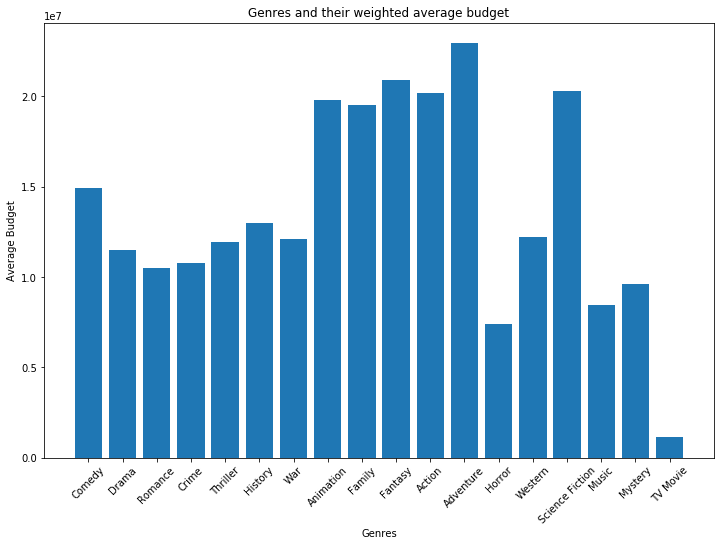

In [254]:
plt.figure(figsize=(12,8));
plt.bar(genre_and_weight_budget.keys(),genre_and_weight_budget.values());
plt.title('Genres and their weighted average budget');
plt.xlabel('Genres');
plt.ylabel('Average Budget');
plt.xticks(rotation=45)
plt.show()